Before we begin, I stumbled across [**this really great blog post**](http://microbe.net/2014/10/22/comparing-the-new-16s-rrna-v4-and-its-primers-to-the-old-primers-results/) from the Knight lab that you should **definitely** check out if you're interested in SSU rRNA gene primers. They have some experimental data up which is great to see.

Let's start by summarizing a few key findings from the [last post]({filename}primers1.ipynb).

1. The 515F target in Bacteria is extremely conserved -- one sequence is found many many times more than any other.
1. Although the bacterial 515F targets are predominantly one sequence, the second and third most abundant bacterial 515F targets differ from the most abundant target near the 3' end.
1. The 515F targets in Archaea and Bacteria have little overlap.
1. Archaeal 515F targets are more evenly distributed than bacterial 515F targets. 
1. The Nanoarchaea appear to have a diagnostic 515F sequence. 

Based on these findings we might ask a few questions:

* Does the 515F primer account for the 3' differences between the three most abundant bacterial targets? If not, what are the implications?
* Does 515F hit Archaea **and** Bacteria equally well?
* Does 515F hit Nanoarchaea in particular?

The questions above imply one version of 515F. In reality, the 515F primer has been modified over time so we should address those questions over a representative collection of 515F primers.

In this post we'll look at two 515F versions and propose an updated version and see how it compares. Let's evaluate the 515F version used by [Bates *et al.* (2010)](http://www.nature.com/ismej/journal/v5/n5/full/ismej2010171a.html) because the authors provide a nice primer analysis in their paper. We'll also look at the 515F version that is on the [Earth Microbiome Project (EMP)](http://www.earthmicrobiome.org/emp-standard-protocols/16s/) website. 

I'm just going to use the ```regex``` ```Python``` module ([here](https://pypi.python.org/pypi/regex)) to evaluate the primers. We need to represent the primers with the degeneracy in regular expression syntax. The ```{e}``` at the end will allow us to enable fuzzy matching. 

In [5]:
versions = {"EMP" : "(GTG[CT]CAGC[CA]GCCGCGGTAA){e}", 
            "Bates" : "(GTGCCAGC[CA]GCCGCGGTAA){e}"}

Ok, let's bring in the ```Python``` modules we need and some IPython extensions.

In [10]:
%matplotlib inline
%load_ext rpy2.ipython
import matplotlib.pyplot as plt
from align import aligner
from skbio import DNA, parse_fasta, SequenceCollection
import pandas as pd
import regex

In [72]:
%%R
library(ggplot2)
library(dplyr); library(tidyr)
library(magrittr)
library(RColorBrewer)
library(gridExtra)

Loading required package: grid


We'll make the same 515F target dataframe as in the [previous post]({filename}primers1.ipynb). 

In [15]:
def parse_tax(line):
    id, tax_str = line.split("\t")
    k, p, c, o, f, g, s = tax_str.rstrip().split(";")
    tax_dict = {"kingdom" : k.split("__")[1],
                "phylum"  : p.split("__")[1],
                "class"   : c.split("__")[1],
                "family"  : f.split("__")[1],
                "order"   : o.split("__")[1],
                "genus"   : g.split("__")[1],
                "species" : s.split("__")[1],
                "id"      : id}
    return tax_dict
    

df = pd.DataFrame.from_records([parse_tax(line) for line in 
                                open("data/gg_13_5_otus/taxonomy/99_otu_taxonomy.txt")])

df.set_index("id", inplace=True)

fn = "data/gg_13_5_otus/rep_set/99_otus.fasta"
degens = DNA.iupac_degenerate_characters()
seqs = SequenceCollection.from_fasta_records([(n, s) for n, s in parse_fasta(fn) 
                                              if not any(i in s for i in degens)], 
                                             DNA)

ids = [seq[0] for seq in seqs.iteritems()]

F515 = DNA("GTGCCAGCCGCCGCGGTAA") #GTGCCAGCMGCCGCGGTAA  M = [CA]

primer_targets_515 = [aligner(F515.sequence, 
                              seq[1].sequence,
                              method = "glocal")[1] 
                      for seq in seqs.iteritems()]

df_targets = df.join(pd.Series(primer_targets_515, index=ids, name = "515F"), how = "left")
df_targets.dropna(axis=0, subset=["515F"], inplace=True)

# <!-- collapse=True -->

Ok, now the fun stuff. Let's define a function that counts substitutions between the target and the primer. If there's an indel in the target, this function returns an empty string. Eventually we'll pass this dataframe into R and it's easy to replace empty strings with R NA values. One quick note: we'll just be working with the ten most abundant targets in Bacteria and Archaea for the following figures.

In [8]:
def count_subs(s, primer_regex):
    subs, ins, dels = regex.fullmatch(primer_regex, s).fuzzy_counts
    if ins or dels:
        return ""
    else:
        return subs

Now we'll add a column to the target dataframe for each primer version. The values are the number of substitutions between the target and the primer.

In [11]:
for key in versions:
    df_targets[key] = df_targets["515F"].apply(lambda x: count_subs(x, versions[key]))

Push the dataframe into R and we're ready to go! I want to make a figure that conveys three bits of information: 

1. The target,
1. the number of mismatches between the primer and the target, and
1. the representation of the target in selected taxonomic groups.

So, let's make a heatmap (sort of) figure where columns are targets (10 most abundant archaeal and bacterial), rows represent 515F primer versions and the color of each cell represents the mismatches between primer and target. We can scale the size of each cell to the count of each target within the given taxon (log scaled). 

In [12]:
%R -i df_targets

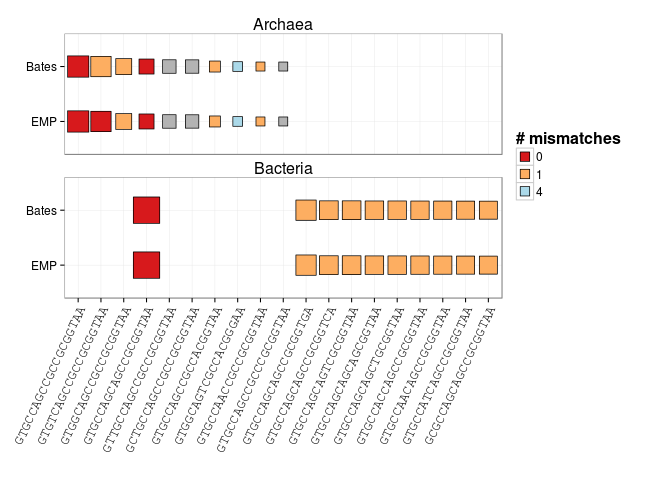

In [17]:
%%R -w 650
d = df_targets %>%
    group_by(kingdom, X515F) %>%
    summarize(count = n(), EMP = first(EMP), Bates = first(Bates)) %>%
    filter(rank(desc(count), ties.method = "random") <= 10) %>%
    arrange(desc(count), kingdom) %>%
    mutate(X515F = factor(X515F, levels = unique(.$X515F))) %>% 
    {
        .[.==""] = NA
        .
    } %>%
    gather(key, value, -count, -kingdom, -X515F)

p = ggplot(d, aes(x = X515F, y = key, size = log(count), fill = value))

p = p + facet_wrap(~kingdom, ncol = 1, scales = "free_y")

p = p + geom_point(shape = 22)

p = p + scale_size_area(max_size = 14)

p = p + scale_fill_manual(values = brewer.pal(4,"RdYlBu"), na.value = "grey70")

p = p + labs(x = "", y = "", fill = "# mismatches")

p = p + theme_bw()

p = p + theme(axis.text.x = element_text(angle = 65, hjust = 1, size = 14, family = "mono"),
              axis.text.y = element_text(size = 12),
              axis.title = element_text(size = 16),
              strip.background = element_blank(),
              strip.text = element_text(size = 16),
              legend.text = element_text(size = 12),
              legend.title = element_text(size = 16))

p = p + guides(fill = guide_legend(override.aes=list(size=5)), size = FALSE)

p

# <!-- collapse=True -->

Cool! You can see that the EMP primer has improved zero mismatch coverage of Archaea (also discussed in [this post](http://microbe.net/2014/10/22/comparing-the-new-16s-rrna-v4-and-its-primers-to-the-old-primers-results/)). There are still mismatches at the 3' end between second and third most abundant bacterial 515F targets with each primer version.

Let's explore what the implications of the 3' end mismatch between primers and bacterial targets might be. I want to look at how each primer hits bacterial phyla. Let's define a function to make this plot. The function will take a couple arguments. One argument will specify the taxon to plot (right now just Bacteria or Archaea) and the other will specify the primer. In this figure rows will be targets (10 most abundant targets) and columns will be taxa. The colors will represent mismatches against the selected primer. Size will be based on relative abundance for the target within the given column. **These figures are somewhat small but you can zoom in by right clicking and opening the figure in a new browser window or tab.** 

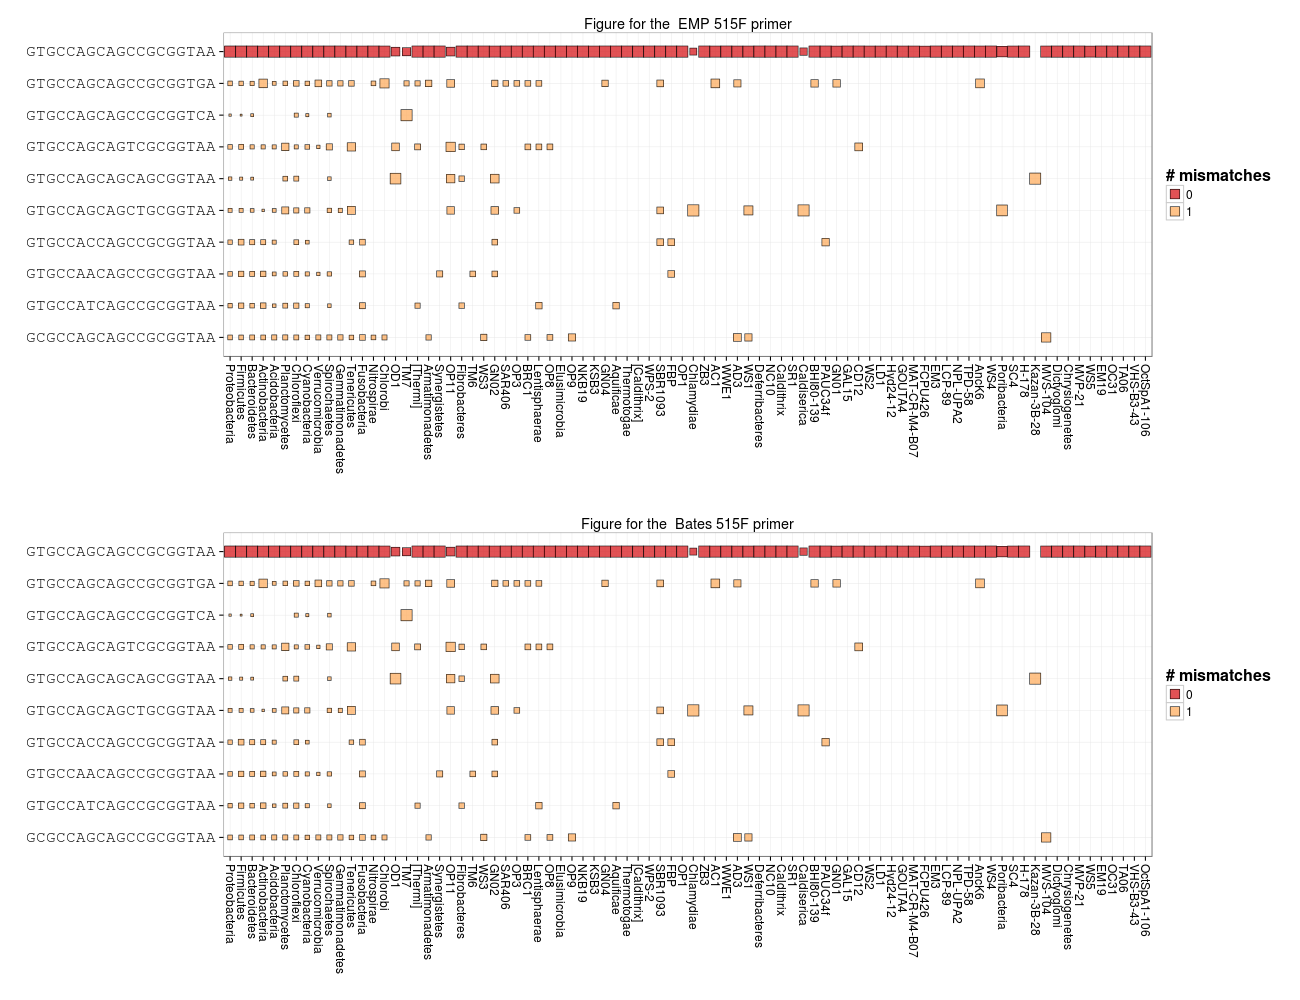

In [83]:
%%R -w 1300 -h 1000
primer_plot = function(taxon = "Bacteria", primer = "EMP") {
    d = df_targets %>%
        {
            .[.==""] = NA
            .
        } %>%
        filter(!is.na(phylum), kingdom == taxon) %>%
        {
            psort = group_by(., phylum) %>% 
                summarize(count = n()) %>% 
                arrange(desc(count)) %>%
                extract2("phylum") %>% as.character
            mutate(., phylum = factor(phylum, levels = psort))
        } %>%
        group_by(phylum, X515F) %>%
        do(summarize(., count = n(), primer = first(.[[primer]]))) %>%
        group_by(phylum) %>%
        mutate(count.relative = count / sum(count)) %>%
        {
            keep = group_by(., X515F) %>%
                summarize(tmp = sum(count)) %>%
                filter(rank(desc(tmp), ties.method = "random") <= 10) %>%
                arrange(tmp) %>%
                extract2("X515F") %>% as.character
            filter(., X515F %in% keep) %>%
                mutate(X515F = factor(X515F, levels = keep), primer = factor(primer, levels = 0:4))
        }


    p = ggplot(d, aes(x = X515F, y = phylum, size = log(count.relative), fill = primer))
               
    p = p + geom_point(shape = 22, alpha = 0.75)

    p = p + labs(x = "", y = "", fill = "# mismatches")

    p = p + scale_fill_manual(values = brewer.pal(4,"RdYlBu"), na.value = "grey70")
    
    p = p + ggtitle(paste("Figure for the ", primer, "515F primer"))

    p = p + theme_bw()

    p = p + theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust = 0.5, size = 12),
                  axis.text.y = element_text(size = 16, family = "mono"),
                  axis.title = element_text(size = 16),
                  strip.background = element_blank(),
                  legend.text = element_text(size = 12),
                  legend.title = element_text(size = 16),
                  strip.text = element_blank())

    p = p + guides(fill = guide_legend(override.aes=list(size=5)), size = FALSE)

    p = p + coord_flip()

    p
}

grid.arrange(primer_plot(), primer_plot(primer = "Bates"), nrow = 2)

# <!-- collapse=True -->

As you can see, the 3' mismatch will probably effect recovery of **TM7** as well as a smattering of sequences throughout the most abundant phyla.

We can make the same plot for Archaea. This highlights how the EMP 515F version hits the Crenarchaea with zero mismatches but neither primer matches the Nanoarchaea targets well.

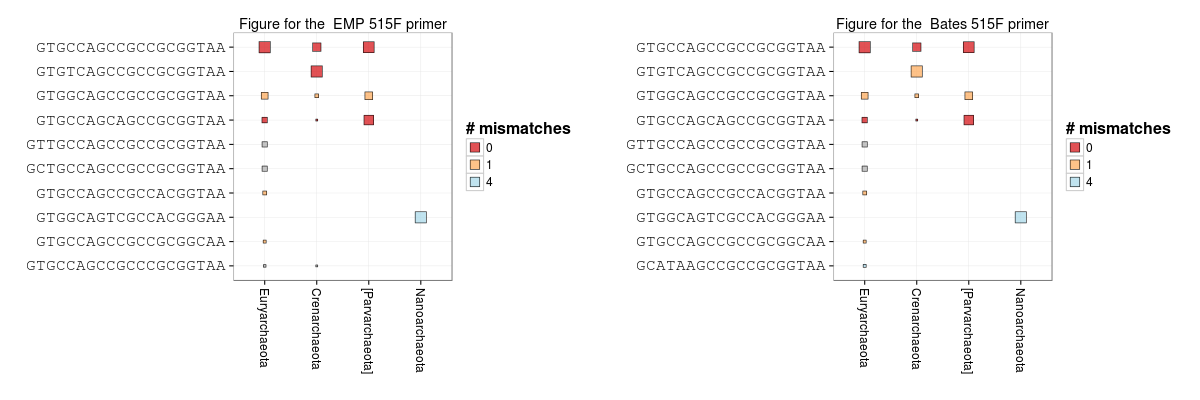

In [84]:
%%R -w 1200 -h 400
grid.arrange(primer_plot(taxon = "Archaea"), 
             primer_plot(taxon = "Archaea", primer = "Bates"), ncol = 2)

It's a bit unrealistic to design the perfect primer. But, it's certainly possible to quantify and explore *in silico* primer bias and to interpret results with the bias in mind. It's really great to see how the EMP folks have improved the 515F primer to hit more Crenarchaea. One suggestion from our analysis today is to add degeneracy at the 3' end to account for TM7 and many members of more abundant groups. The current EMP 515F primer is **5'-GTGYCAGCMGCCGCGGTAA-3'** but it might be useful to change that to **5'-GTGYCAGCMGCCGCGGTVA-3'**.

I'm also wondering if you could just chop off the last two nucleotides? This would drop the annealing temp but perhaps it would be negligible(?).

**Here is what the proposed 515F looks like against Bacteria.** You can see that it hits TM7 and the second most abundant target with zero mismatches.

In [87]:
df_targets["proposed"] = df_targets["515F"].apply(lambda x: count_subs(x, "(GTG[CT]CAGC[CA]GCCGCGGT[AGC]A){e}"))
%R -i df_targets

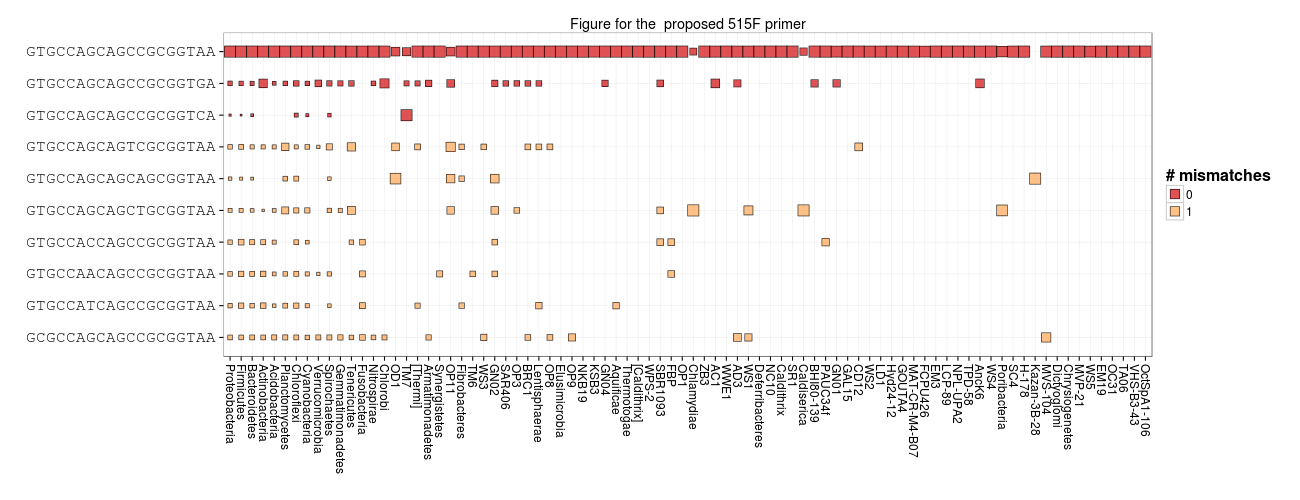

In [90]:
%%R -w 1300 -h 500
primer_plot(primer = "proposed")

And we can address the questions from above.

* Do 515F primers account for the 3' differences between the three most abundant targets? If not, what are the implications?

> No. Current 515F primers are biased against TM7 and have mismatches at the 3' end with sequences throughout the most commonly found bacterial phyla (although current primers do hit the most abundant target in Archaea and Bacteria with zero mismatches and there's only one mismatch between current targets and most bacterial targets). So, on the whole, the latest primers are great but still room for improvement.

* Does 515F hit Archaea **and** Bacteria equally well?

> I would say yes, tentatively. The latest EMP primer appears to hit most Archaea with zero mismatches. It also hits most Bacteria with one mismatch or less.

* Does 515F hit Nanoarchaea in particular?

> No. Nanoarchaea have distinct 515F targets and 515F primers are biased against Nanoarchaea *in silico.*